# Face detection, tracking and matching:

## Import dependencies:

In [1]:
import face_recognition
import cv2

In [2]:
import os
from os.path import basename
import glob
import sys
import types
import subprocess
from random import randint
import json
import gc

In [3]:
import skvideo.io
import numpy as np
import scipy.misc
from skimage.transform import rescale, resize, downscale_local_mean

In [4]:
import PIL

In [5]:
import keras
from keras.preprocessing import image
from keras.models import model_from_json
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.applications.inception_v3 import preprocess_input

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## OpenCV version check:

In [6]:
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    print ("Update OpenCV ...")
    sys.exit(1)

## Load video files:

In [7]:
source = '../video/One_Direction-Drag_Me_Down.mp4'

In [8]:
try:
    video_capture = cv2.VideoCapture(source)
    print ("Imported video using OpenCV ...")
except:
    video_capture =  skvideo.io.vread(source)
    print ("Imported video using sci-kit video ...")

Imported video using OpenCV ...


## Initialize variables for video processing:

In [9]:
sgd = SGD(lr=1e-7, decay=0.5, momentum=1, nesterov=True)
rms = RMSprop(lr=1e-7, rho=0.9, epsilon=1e-08, decay=0.0)
ada = Adagrad(lr=1e-7, epsilon=1e-08, decay=0.0)
optimizer = sgd
IMG_HEIGHT = 299
IMG_WIDTH = 299

In [10]:
length = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

In [11]:
save_path = "../proc_vid.mp4"
save_audio = "../audio.wav"
save_path_w_audio = "../proc_vid_audio.mp4"
output_dir = '../output/'

In [12]:
face_locations = []
face_encodings = []
face_names = []
frame_number = 0
face_count = 0

In [13]:
w, h = int(video_capture.get(3)),int(video_capture.get(4))
print ("Source image width: "+ str(w))
print ("Source image height: "+ str(h))

fps = video_capture.get(cv2.CAP_PROP_FPS)
print ("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

Source image width: 1280
Source image height: 720
Frames per second using video.get(cv2.CAP_PROP_FPS) : 23.976025018098067


In [14]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(save_path, fourcc, fps, (w,h), True)

In [15]:
reference_image_path = "../ref_img/"
file_list = glob.glob(reference_image_path + '/*.jpg')

In [16]:
n_proc_frames = length
resize_img = False
verbose = True
gen_train_img = True
interleaved = False
use_deep_learning = True
annotate = True
process_this_frame = True
inverse_scale_factor = 1

In [17]:
def compile_model(model):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
def load_prediction_model(args):
    try:
        with open(args.config_file[0]) as json_file:
              model_json = json_file.read()
        model = model_from_json(model_json)
    except:
          print ("Please specify a model configuration file ...")
          sys.exit(1)
    try:
          model.load_weights(args.weights_file[0])
          print ("Loaded model weights from: " + str(args.weights_file[0]))
    except:
          print ("Error loading model weights ...")
          sys.exit(1)
    try:
        with open(args.labels_file[0]) as json_file:
            labels = json.load(json_file)
        print ("Loaded labels from: " + str(args.labels_file[0]))
    except:
        print ("No labels loaded ...")
        sys.exit(1)
    return model, labels

In [19]:
def gen_predict(model):
    try:
        compile_model(model)
        print ("Model successfully compiled ...")
    except:
        print ("Model failed to compile ...")

    print ("Compiling predictor function ...")                                          # to avoid the delay during video capture.
    _ = model.predict(np.zeros((1, n, n, 3), dtype=np.float32), batch_size=1)
    print ("Compilation completed ...")

In [20]:
args = types.SimpleNamespace()
args.config_file = ['../model/trained_config.json']
args.weights_file = ['../model/trained_weights.model']
args.labels_file = ['../model/trained_labels.json']
args.output_dir = ['../output/']

In [21]:
model, labels = load_prediction_model(args)

Loaded model weights from: ../model/trained_weights.model
Loaded labels from: ../model/trained_labels.json


In OpenCV using: [interpolation = cv2.INTER_CUBIC](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) argument in cv2.resize, performs a bi-cubic interpolation over 4x4 pixel neighborhood.

In [24]:
while (video_capture.isOpened()):    
    ret, frame = video_capture.read() # Grab a single frame of video
    
    frame_number += 1
    
    if resize_img ==True:
        isf = inverse_scale_factor
        small_frame = cv2.resize(frame, (0, 0), fx=(1/isf), fy=(1/isf)) # Resize frame of video to 1/inverse_scale_factor size for faster processing
    else:
        isf = 1
        small_frame = frame
    if frame_number <=n_proc_frames:
        if ret ==True:
            if process_this_frame:
                face_locations = face_recognition.face_locations(small_frame) # Find all the faces and face encodings in the current frame of video
                face_encodings = face_recognition.face_encodings(small_frame, face_locations)
                face_names = []
                if annotate == True or gen_train_img == True:
                    for face_encoding in face_encodings:
                        for file_path in file_list:
                            reference_image = face_recognition.load_image_file(file_path)
                            try:
                                reference_face_encoding = face_recognition.face_encodings(reference_image)[0]
                                if verbose == True:
                                    print ("Processed face encodings ...")
                                else:
                                    pass
                            except:
                                if verbose == True:
                                    print("Failed processing face encodings ...")
                                else:
                                    pass
                            if annotate == True:
                                name_ID = (os.path.splitext(basename(file_path))[0])
                                name_ID = name_ID.replace("_", " ")
                                match = face_recognition.compare_faces([reference_face_encoding], face_encoding) # See if the face is a match for the known face(s)
                                name = "Unknown"
                                if match[0]:
                                    name = name_ID
                                face_names.append(name)
                            else:
                                pass
                else:
                    if verbose == True:
                        print ("Skipping face recognition mode ...")
                    else:
                        pass
            else:
                if verbose == True:
                    print ("Skipping frame ...")
                else:
                    pass
            if interleaved == True:
                process_this_frame = not process_this_frame # Only process every other frame of video to save time
            else:
                process_this_frame = process_this_frame

            # Display the results
            for (top, right, bottom, left), name in zip(face_locations, face_names):
                # Scale back up face locations since the frame we detected in was scaled to scaling factor size
                top *= int(isf)
                right *= int(isf)
                bottom *= int(isf)
                left *= int(isf)
                # Draw an ellipse around the face
                ex = left
                ey = top
                ew = int(abs(right - ex))
                eh = int(abs(bottom - ey))
                p1 = int(ew/2 + ex)
                p2 = int(eh/2 + ey)
                h1 = int(ew/2)
                h2 = int(eh/2)
                square = frame[max((ey-eh//2,0)):ey+3*eh//2, max((ex-ew//2,0)):ex+3*ew//2]
                if gen_train_img == True:
                    random_number = randint(10000000, 99999999)
                    random_number = str(random_number)
                    cv2.imwrite(os.path.join(output_dir+"//"+str(random_number)+"frame_%d.jpg" % face_count), square)
                    if verbose == True:
                        print ("Saved frame: "+ str(face_count)+" with face detected ..." )
                    else:
                        pass
                    face_count += 1
                else:
                    pass
                cv2.ellipse(frame, (p1, p2), (h1,h2), 0,0,360, (0,255,0), 2)
                if use_deep_learning == True and annotate == True:
                    square = cv2.resize(square.astype(np.float32),    \
                                        dsize=(IMG_WIDTH, IMG_HEIGHT),\
                                        interpolation = cv2.INTER_CUBIC)
                    try:
                        _X_ = image.img_to_array(square)
                        del (square)
                        _X_ = np.expand_dims(_X_, axis=0)
                        _X_ = preprocess_input(_X_)
                        probabilities = model.predict(_X_, batch_size=1).flatten()
                        del (_X_)
                        prediction = labels[np.argmax(probabilities)]
                        name = (str(prediction)).replace("_", " ")
                        print ("Face recognition using deep-learning ...")
                        print (prediction + "\t" + "\t".join(map(lambda x: "%.2f" % x, probabilities)))
                        print (str(prediction))
                        del (prediction)
                    except:
                        print ("Failed to create a prediction ...")         
                else:
                    pass
                if annotate == True:
                    font = cv2.FONT_HERSHEY_DUPLEX
                    cv2.rectangle(frame, (p1 - 100, bottom - 2), (p1 + 100, bottom + 33), (0, 0, 255), cv2.FILLED) 
                    cv2.putText(frame, name, (p1  - 94, bottom + 23 ), font, 0.75, (255, 255, 255), 1) # Draw a label with a name below the face
                else:
                    if verbose == True:
                        print ("No identifiers to annotate. Try setting annotate flag to True ...")
                    else:
                        pass
            try:
                video_writer.write(frame)
                if verbose == True:
                    print("Processed frame {} / {}".format(frame_number, length))
                else:
                    pass
            except:
                if verbose == True:
                    print("Failed writing frame {} / {}".format(frame_number, length))
                else:
                    pass
        else:
            if verbose == True:
                print("No frame to process ...")
            else:
                pass
    else:
        if verbose == True:
            print ("Processed "+ str(n_proc_frames) + " frames")
            print ("Detected " + str(face_count) + " faces" )
        else:
            print ("Detected " + str(face_count) + " faces" )
        break

Processed frame 1 / 200
Processed frame 2 / 200
Processed frame 3 / 200
Processed frame 4 / 200
Processed frame 5 / 200
Processed frame 6 / 200
Processed frame 7 / 200
Processed frame 8 / 200
Processed frame 9 / 200
Processed frame 10 / 200
Processed frame 11 / 200
Processed frame 12 / 200
Processed frame 13 / 200
Processed frame 14 / 200
Processed frame 15 / 200
Processed frame 16 / 200
Processed frame 17 / 200
Processed frame 18 / 200
Processed frame 19 / 200
Processed frame 20 / 200
Processed frame 21 / 200
Processed frame 22 / 200
Processed frame 23 / 200
Processed frame 24 / 200
Processed frame 25 / 200
Processed frame 26 / 200
Processed frame 27 / 200
Processed face encodings ...
Saved frame: 0 with face detected ...
Face recognition using deep-learning ...
Unknown	0.01	0.26	0.11	0.13	0.49
Unknown
Processed frame 28 / 200
Processed face encodings ...
Saved frame: 1 with face detected ...
Face recognition using deep-learning ...
Liam_Payne	0.02	0.39	0.20	0.10	0.29
Liam_Payne
Proce

Face recognition using deep-learning ...
Louis_Tomlinson	0.02	0.17	0.38	0.07	0.36
Louis_Tomlinson
Processed frame 46 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 48 with face detected ...
Face recognition using deep-learning ...
Unknown	0.06	0.26	0.11	0.12	0.44
Unknown
Saved frame: 49 with face detected ...
Face recognition using deep-learning ...
Unknown	0.02	0.33	0.25	0.05	0.35
Unknown
Saved frame: 50 with face detected ...
Face recognition using deep-learning ...
Unknown	0.00	0.25	0.04	0.01	0.70
Unknown
Processed frame 47 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 51 with face detected ...
Face recognition using deep-learning ...
Unknown	0.05	0.27	0.12	0.15	0.40
Unknown
Saved frame: 52 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.01	0.23	0.35	0.06	0.35
Louis_Tomlinson
Saved frame: 53 with face detected ...
Face recognition u

Face recognition using deep-learning ...
Unknown	0.02	0.08	0.12	0.10	0.68
Unknown
Saved frame: 99 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.02	0.33	0.45	0.05	0.16
Louis_Tomlinson
Processed frame 63 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 100 with face detected ...
Face recognition using deep-learning ...
Unknown	0.02	0.26	0.10	0.02	0.60
Unknown
Saved frame: 101 with face detected ...
Face recognition using deep-learning ...
Unknown	0.02	0.10	0.12	0.10	0.65
Unknown
Saved frame: 102 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.00	0.08	0.86	0.01	0.04
Louis_Tomlinson
Saved frame: 103 with face detected ...
Face recognition using deep-learning ...
Unknown	0.01	0.09	0.16	0.02	0.71
Unknown
Processed frame 64 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 104 with fa

Face recognition using deep-learning ...
Unknown	0.08	0.26	0.12	0.22	0.31
Unknown
Saved frame: 149 with face detected ...
Face recognition using deep-learning ...
Unknown	0.01	0.03	0.03	0.01	0.92
Unknown
Saved frame: 150 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.00	0.12	0.81	0.02	0.05
Louis_Tomlinson
Processed frame 78 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 151 with face detected ...
Face recognition using deep-learning ...
Niall_Horan	0.06	0.28	0.15	0.30	0.21
Niall_Horan
Saved frame: 152 with face detected ...
Face recognition using deep-learning ...
Unknown	0.01	0.17	0.07	0.05	0.70
Unknown
Saved frame: 153 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.00	0.30	0.45	0.03	0.22
Louis_Tomlinson
Processed frame 79 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 154 with face detected ...
Face

Face recognition using deep-learning ...
Liam_Payne	0.04	0.46	0.06	0.05	0.39
Liam_Payne
Saved frame: 199 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.01	0.39	0.46	0.03	0.11
Louis_Tomlinson
Saved frame: 200 with face detected ...
Face recognition using deep-learning ...
Liam_Payne	0.03	0.30	0.26	0.21	0.21
Liam_Payne
Saved frame: 201 with face detected ...
Face recognition using deep-learning ...
Unknown	0.03	0.08	0.07	0.01	0.81
Unknown
Processed frame 92 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 202 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.01	0.36	0.50	0.03	0.10
Louis_Tomlinson
Saved frame: 203 with face detected ...
Face recognition using deep-learning ...
Unknown	0.02	0.41	0.06	0.07	0.45
Unknown
Saved frame: 204 with face detected ...
Face recognition using deep-learning ...
Unknown	0.06	0.10	0.24	0.27	0.33
Unknown
S

Face recognition using deep-learning ...
Unknown	0.01	0.03	0.02	0.02	0.92
Unknown
Processed frame 104 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 250 with face detected ...
Face recognition using deep-learning ...
Niall_Horan	0.09	0.08	0.27	0.41	0.15
Niall_Horan
Saved frame: 251 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.02	0.33	0.34	0.04	0.27
Louis_Tomlinson
Saved frame: 252 with face detected ...
Face recognition using deep-learning ...
Liam_Payne	0.03	0.63	0.07	0.03	0.24
Liam_Payne
Saved frame: 253 with face detected ...
Face recognition using deep-learning ...
Unknown	0.01	0.05	0.10	0.02	0.82
Unknown
Processed frame 105 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 254 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.02	0.35	0.35	0.06

Face recognition using deep-learning ...
Niall_Horan	0.07	0.15	0.24	0.32	0.22
Niall_Horan
Saved frame: 301 with face detected ...
Face recognition using deep-learning ...
Liam_Payne	0.04	0.79	0.06	0.02	0.10
Liam_Payne
Processed frame 115 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 302 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.01	0.16	0.43	0.09	0.30
Louis_Tomlinson
Saved frame: 303 with face detected ...
Face recognition using deep-learning ...
Unknown	0.00	0.00	0.00	0.00	0.99
Unknown
Saved frame: 304 with face detected ...
Face recognition using deep-learning ...
Unknown	0.04	0.03	0.03	0.01	0.90
Unknown
Saved frame: 305 with face detected ...
Face recognition using deep-learning ...
Niall_Horan	0.05	0.12	0.16	0.37	0.29
Niall_Horan
Saved frame: 306 with face detected ...
Face recognition using deep-learning ...
Liam_Payne	0.01	0.

Face recognition using deep-learning ...
Niall_Horan	0.10	0.11	0.18	0.48	0.14
Niall_Horan
Saved frame: 352 with face detected ...
Face recognition using deep-learning ...
Unknown	0.00	0.01	0.01	0.01	0.97
Unknown
Saved frame: 353 with face detected ...
Face recognition using deep-learning ...
Liam_Payne	0.01	0.92	0.04	0.01	0.02
Liam_Payne
Processed frame 125 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 354 with face detected ...
Face recognition using deep-learning ...
Unknown	0.04	0.03	0.04	0.01	0.88
Unknown
Saved frame: 355 with face detected ...
Face recognition using deep-learning ...
Louis_Tomlinson	0.01	0.19	0.61	0.03	0.16
Louis_Tomlinson
Saved frame: 356 with face detected ...
Face recognition using deep-learning ...
Niall_Horan	0.20	0.16	0.20	0.31	0.14
Niall_Horan
Saved frame: 357 with face detected ...
Face recognition using deep-le

Face recognition using deep-learning ...
Liam_Payne	0.00	0.94	0.05	0.00	0.01
Liam_Payne
Saved frame: 403 with face detected ...
Face recognition using deep-learning ...
Unknown	0.00	0.14	0.14	0.07	0.64
Unknown
Saved frame: 404 with face detected ...
Face recognition using deep-learning ...
Unknown	0.08	0.06	0.17	0.03	0.67
Unknown
Saved frame: 405 with face detected ...
Face recognition using deep-learning ...
Unknown	0.00	0.04	0.01	0.00	0.94
Unknown
Processed frame 134 / 200
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Processed face encodings ...
Saved frame: 406 with face detected ...
Face recognition using deep-learning ...
Unknown	0.03	0.19	0.30	0.11	0.37
Unknown
Saved frame: 407 with face detected ...
Face recognition using deep-learning ...
Niall_Horan	0.06	0.07	0.18	0.40	0.29
Niall_Horan
Saved frame: 408 with face detected ...
Face recognition using de

Face recognition using deep-learning ...
Harry_Styles	0.98	0.00	0.00	0.00	0.01
Harry_Styles
Processed frame 146 / 200
Processed face encodings ...
Saved frame: 455 with face detected ...
Face recognition using deep-learning ...
Harry_Styles	0.98	0.00	0.00	0.01	0.00
Harry_Styles
Processed frame 147 / 200
Processed face encodings ...
Saved frame: 456 with face detected ...
Face recognition using deep-learning ...
Harry_Styles	0.99	0.00	0.00	0.00	0.00
Harry_Styles
Processed frame 148 / 200
Processed face encodings ...
Saved frame: 457 with face detected ...
Face recognition using deep-learning ...
Harry_Styles	0.99	0.00	0.00	0.00	0.00
Harry_Styles
Processed frame 149 / 200
Processed face encodings ...
Saved frame: 458 with face detected ...
Face recognition using deep-learning ...
Harry_Styles	0.98	0.00	0.01	0.01	0.00
Harry_Styles
Processed frame 150 / 200
Processed face encodings ...
Saved frame: 459 with face detected ...
Face recognition using deep-learning ...
Harry_Styles	0.99	0.00	0

Face recognition using deep-learning ...
Harry_Styles	0.99	0.00	0.00	0.00	0.00
Harry_Styles
Processed frame 190 / 200
Processed face encodings ...
Saved frame: 499 with face detected ...
Face recognition using deep-learning ...
Harry_Styles	0.99	0.00	0.00	0.00	0.00
Harry_Styles
Processed frame 191 / 200
Processed face encodings ...
Saved frame: 500 with face detected ...
Face recognition using deep-learning ...
Harry_Styles	0.99	0.00	0.00	0.00	0.00
Harry_Styles
Processed frame 192 / 200
Processed face encodings ...
Saved frame: 501 with face detected ...
Face recognition using deep-learning ...
Harry_Styles	0.99	0.00	0.00	0.00	0.00
Harry_Styles
Processed frame 193 / 200
Processed face encodings ...
Processed face encodings ...
Saved frame: 502 with face detected ...
Face recognition using deep-learning ...
Harry_Styles	0.99	0.00	0.00	0.00	0.00
Harry_Styles
Saved frame: 503 with face detected ...
Face recognition using deep-learning ...
Unknown	0.04	0.07	0.04	0.01	0.85
Unknown
Processed

## Release handle reading the video file or webcam:

In [25]:
video_capture.release()
video_writer.release()

## Extract audio from a video file:

In [26]:
cmd = 'ffmpeg -i %s -ab 320000 -ac 2 -ar 44100 -vn %s' % (source, save_audio)
print (cmd)
subprocess.call(cmd, shell=True)

ffmpeg -i ../video/One_Direction-Drag_Me_Down.mp4 -ab 320000 -ac 2 -ar 44100 -vn ../audio.wav


0

## Copy audio track from one video to another:

In [27]:
cmd = 'ffmpeg -y -i %s -i %s -shortest -c:v copy -c:a aac -b:a 256k  %s' % (save_path, save_audio, save_path_w_audio)
print (cmd)
subprocess.call(cmd, shell=True)
print('Muxing completed ...')
print('Saved output file to: %s' % (save_path_w_audio))

ffmpeg -y -i ../proc_vid.mp4 -i ../audio.wav -shortest -c:v copy -c:a aac -b:a 256k  ../proc_vid_audio.mp4
Muxing completed ...
Saved output file to: ../proc_vid_audio.mp4


## Visualize deep-learning model architecture:

In [22]:
from keras.utils import plot_model 
import pydot 
import graphviz # apt-get install -y graphviz libgraphviz-dev 
from IPython.display import SVG 
from keras.utils.vis_utils import model_to_dot

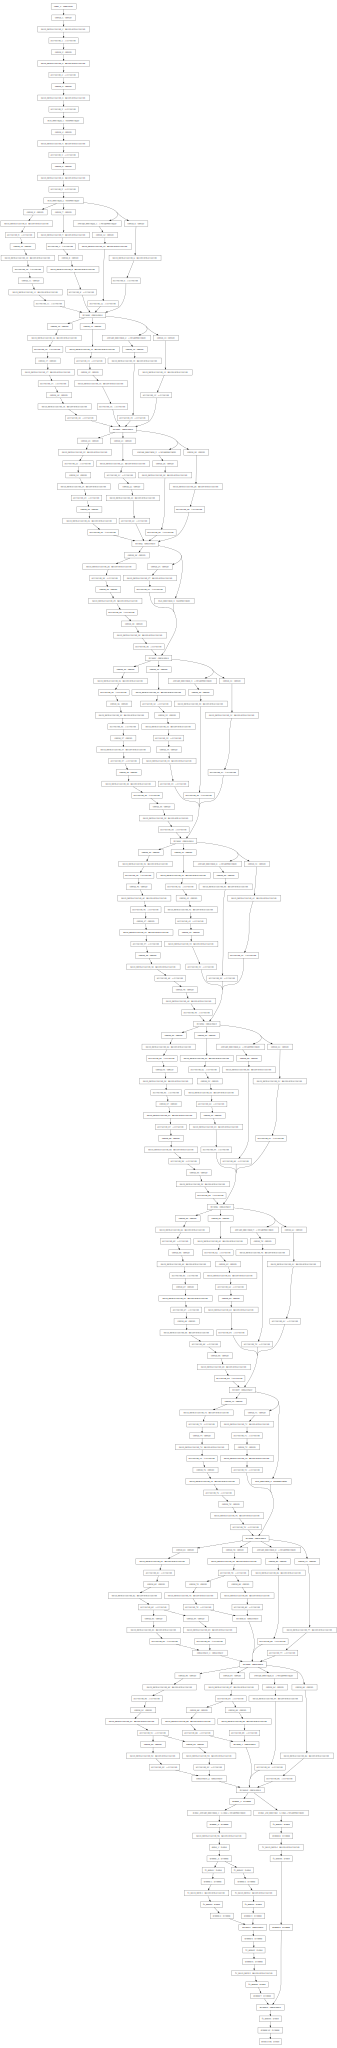

In [23]:
plot_model(model, to_file= os.path.join(args.output_dir[0] + '/model_face_detection.png')) 
SVG(model_to_dot(model).create(prog='dot', format='svg'))